In [43]:
import numpy as np
import pandas as pd
import random
import pygame
from pygame.locals import *
import math
import time
import matplotlib.pyplot as plt
import sys

In [32]:
class TologatosJatek:
    def __init__(self, tabla):
        #  A tabla egy 2 dimenzios 4x4-es meretu numpy array
        #  A tabla elemei 0-tol 15-ig a szamok ahol a 0 jelenti az ures mezot
        if not isinstance(tabla, np.ndarray):
            raise ValueError("Táblaként egy numpy.ndarray-t kell megadni")
        elif tabla.shape != (4, 4):
            tabla.resize((4, 4))
        self.A = tabla
        self.lepesek = []  # ebbe a listaba mentem el a megtett lepeseket
        self.lepesekszama = 0
        self.d = {}  # d egy dictionary ahol minden szamhoz feljegyezzuk hogy hol szerepel a tablaban
        for i in range(4):
            for j in range(4):
                self.d[self.A[i][j]] = [i, j]

    def megoldhatosag(self):
        """
        Ez metodus eldonti, hogy kirakhato-e az aktualis allas
        Pontosan akkor megoldhato az inv valtozo paratlan
        :return: True ha kirakhato a tabla es False ha nem
        """
        inv = 0
        for i in range(1, 16):
            if not self.A[int((i - i % 4) / 4)][i % 4] == 0:
                for j in range(i):
                    if self.A[int((j - j % 4) / 4)][j % 4] == 0:
                        pass
                    elif self.A[int((i - i % 4) / 4)][i % 4] < self.A[int((j - j % 4) / 4)][j % 4]:
                        inv = inv + 1
        inv += self.d[0][0]
        if inv % 2 == 0:
            return False
        elif inv % 2 == 1:
            return True

    def nullrendezes(self):
        """
        Ez a metodus leviszi a 0-t a jobb also sarokba
        """
        [k, l] = self.d[0]
        self.le(3 - k)
        self.jobbra(3 - l)

    def fel(self, j=1):
        #  j parameter jelenti, hogy hanszor ismeteljuk a felfele mozgatast
        for _ in range(j):
            self.A[self.d[0][0] - 1][self.d[0][1]], self.A[self.d[0][0]][self.d[0][1]] = \
                self.A[self.d[0][0]][self.d[0][1]], self.A[self.d[0][0] - 1][self.d[0][1]]
            self.d[self.A[self.d[0][0]][self.d[0][1]]] = [self.d[0][0], self.d[0][1]]
            self.d[0] = [self.d[0][0] - 1, self.d[0][1]]
            self.lepesek.append("fel")
        self.lepesekszama += j

    def le(self, j=1):
        #  j parameter jelenti, hogy hanszor ismeteljuk a lefele mozgatast
        for _ in range(j):
            self.A[self.d[0][0] + 1][self.d[0][1]], self.A[self.d[0][0]][self.d[0][1]] = \
                self.A[self.d[0][0]][self.d[0][1]], self.A[self.d[0][0] + 1][self.d[0][1]]
            self.d[self.A[self.d[0][0]][self.d[0][1]]] = [self.d[0][0], self.d[0][1]]
            self.d[self.A[self.d[0][0]][self.d[0][1]]] = [self.d[0][0], self.d[0][1]]
            self.d[0] = [self.d[0][0] + 1, self.d[0][1]]
            self.lepesek.append("le")
        self.lepesekszama += j

    def jobbra(self, j=1):
        #  j parameter jelenti, hogy hanszor ismeteljuk a jobbra mozgatast
        for _ in range(j):
            self.A[self.d[0][0]][self.d[0][1] + 1], self.A[self.d[0][0]][self.d[0][1]] = self.A[self.d[0][0]][
                                                                                             self.d[0][1]], \
                                                                                         self.A[self.d[0][0]][
                                                                                             self.d[0][1] + 1]
            self.d[self.A[self.d[0][0]][self.d[0][1]]] = [self.d[0][0], self.d[0][1]]
            self.d[0] = [self.d[0][0], self.d[0][1] + 1]
            self.lepesek.append("jobbra")
        self.lepesekszama += j

    def balra(self, j=1):
        #  j parameter jelenti, hogy hanszor ismeteljuk a balra mozgatast
        for _ in range(j):
            self.A[self.d[0][0]][self.d[0][1] - 1], self.A[self.d[0][0]][self.d[0][1]] = self.A[self.d[0][0]][
                                                                                             self.d[0][1]], \
                                                                                         self.A[self.d[0][0]][
                                                                                             self.d[0][1] - 1]
            self.d[self.A[self.d[0][0]][self.d[0][1]]] = [self.d[0][0], self.d[0][1]]
            self.d[0] = [self.d[0][0], self.d[0][1] - 1]
            self.lepesek.append("balra")
        self.lepesekszama += j

    def kor(self, i, j, k, e):
        """
        Egy teglalap menten korbe forgatja az ures mezot
        :param i: teglalap magassaga
        :param j: teglalap szelessege
        :param k: forgatasok szama
        :param e: forgatas iranya, 1 ha pozitiv a forgasirany es 0 ha negativ
        """
        if e > 0:
            for _ in range(k):
                self.fel(i)
                self.balra(j)
                self.le(i)
                self.jobbra(j)
        if e < 0:
            for _ in range(k):
                self.balra(j)
                self.fel(i)
                self.jobbra(j)
                self.le(i)

    def csere(self, l, k):
        # az l és k szomszédos mezőkön álló számokat megcseréli
        x = l[0] - self.d[0][0]
        y = l[1] - self.d[0][1]
        if l[0] - k[0] == 0:
            self.kor(abs(x), abs(y), 1, -1)
        if l[1] - k[1] == 0:
            self.kor(abs(x), abs(y), 1, 1)

    def utvonal(self, n, l):
        # az n számot tartalmazó mezőből csinál egy utat az l mezőbe
        if l[1] - self.d[n][1] > 0:
            if self.d[n][0] < 3:
                self.kor(3 - self.d[n][0], 3, l[1] - self.d[n][1], 1)
            if self.d[n][0] == 3:
                self.kor(1, 3, self.d[n][1] + l[1] + 1, 1)
        x = l[0] - self.d[n][0]
        y = l[1] - self.d[n][1]
        v = []
        if self.d[n][0] == 3:
            if y != 0 and x != 0:
                for i in range(1, int(abs(x)) + 1):
                    v.append([self.d[n][0] + i * int(x / abs(x)), self.d[n][1]])
                for i in range(1, int(abs(y)) + 1):
                    v.append([self.d[n][0] + x, self.d[n][1] + i * int(y / abs(y))])

            else:
                if y != 0:
                    for i in range(1, int(abs(y)) + 1):
                        v.append([self.d[n][0], self.d[n][1] + i * int(y / abs(y))])
                if x != 0:
                    for i in range(1, int(abs(x)) + 1):
                        v.append([self.d[n][0] + i * int(x / abs(x)), self.d[n][1]])
        else:

            if y != 0 and x != 0:
                for i in range(1, int(abs(y)) + 1):
                    v.append([self.d[n][0], self.d[n][1] + i * int(y / abs(y))])
                for i in range(1, int(abs(x)) + 1):
                    v.append([self.d[n][0] + i * int(x / abs(x)), self.d[n][1] + y])
            else:
                if y != 0:
                    for i in range(1, int(abs(y)) + 1):
                        v.append([self.d[n][0], self.d[n][1] + i * int(y / abs(y))])
                if x != 0:
                    for i in range(1, int(abs(x)) + 1):
                        v.append([self.d[n][0] + i * int(x / abs(x)), self.d[n][1]])

        return v

    def fv(self, n, l):
        """
        Az n szamot elviszi az l koordinataju mezobe
        :param n: 0 es 15 kozotti egesz szam
        :param l: 2 elemu lista, ahol az elso koordinata a sor, a masodik az oszlop sorszamat jeloli
        """
        v = self.utvonal(n, l)
        if len(v) != 0:
            for i in range(len(v)):
                self.csere(v[i], self.d[n])

    def kirakas(self):
        if self.megoldhatosag() == False:
            raise Exception("A tábla nem kirakható!")
        self.nullrendezes()
        if (self.A[0] == [1, 2, 3, 4]).all() == False:
            self.fv(2, [0, 0])
            self.fv(3, [0, 1])
            self.fv(4, [0, 2])
            if self.d[1] == [0, 3]:
                self.kor(3, 3, 1, 1)
                self.kor(2, 3, 1, -1)
                self.kor(3, 3, 1, -1)
            self.fv(1, [1, 0])
            self.kor(3, 3, 1, 1)
        if (self.A[1] == [5, 6, 7, 8]).all() == False:
            self.fv(6, [1, 0])
            self.fv(7, [1, 1])
            self.fv(8, [1, 2])
            if self.d[5] == [1, 3]:
                self.kor(2, 3, 1, 1)
                self.kor(1, 3, 1, -1)
                self.kor(2, 3, 1, -1)
            self.fv(5, [2, 0])
            self.kor(2, 3, 1, 1)
        if self.A[2][0] != 9 or self.A[3][0] != 13:
            self.fv(13, [2, 0])
            if self.d[9] == [3, 0]:
                self.kor(1, 3, 3, 1)
                self.kor(1, 1, 1, -1)
                self.kor(1, 3, 1, 1)
                self.kor(1, 1, 2, -1)
                self.kor(1, 3, 2, 1)
            else:
                self.fv(9, [2, 1])
                self.kor(1, 3, 6, 1)
        if self.A[2][1] != 10 or self.A[3][1] != 14:
            self.fv(14, [2, 1])
            if self.d[10] == [3, 1]:
                self.kor(1, 2, 2, 1)
                self.kor(1, 1, 1, -1)
                self.kor(1, 2, 1, 1)
                self.kor(1, 1, 2, -1)
                self.kor(1, 2, 1, 1)
            else:
                self.fv(10, [2, 2])
                self.kor(1, 2, 4, 1)
        if self.d[11] == [3, 2]:
            self.kor(1, 1, 2, -1)
        if self.d[11] == [2, 3]:
            self.kor(1, 1, 1, -1)

## Algoritmus
Az algoritmus röviden összefoglalva először az első sort rakja ki, aztán a második sort, majd az 1.oszlopot, ezt követően a 2.oszlopot, és legvégül az alsó 2x2-est forgatja helyére. \
Az első sor kirakása úgy zajlik, hogy az 2-est a [0,0] mezőre, a 3-ast a [0,1] mezőre, a 4-est a [0,2], majd az 1-est az [1,0] mezőre visszük és a táblaszélét körbeforgatjuk, hogy az első sor helyére kerüljön. \
Egy mező helyére mozgatásánál az üres mező a jobb alsó sarokból indul és oda ér vissza, mivel köröket ír le a mozgásával. \
(Az algoritmus részletes ismertetése a bemutatón fog zajlani)

## Megoldhatóság
Nézzük meg az inverziószámot, és ehhez adjuk hozzá az üres mező sorának sorszámát.\
Pontosan akkor megoldható ha a kapott érték páratlan.\
Nézzük ennek az összegnek a paritását egy lépésnél: ha vízszintesen lépünk, akkor ugyanaz marad az összeg paritása, mivel ekkor az inverziószám sem tud változni. Ha pedig függőlegesen, akkor az inverziószám is és a másik érték is páratlannal változik, így az összeg paritása semelyik lépésnél sem változik. (Függőleges mozgatásnál az inverziószám azért páratlannal változik, mivel pontosan 3 mező van a jelenlegi és az új helye között)

In [33]:
def generate_start_position():
    """
    Ez a fuggveny general egy random megoldhato tablat
    :return: 4x4 numpy.ndarray
    """
    elements = np.array(range(16))
    table = np.random.permutation(elements).reshape((4, 4))
    example = TologatosJatek(table)
    if example.megoldhatosag() == False:  # If the table not solvable, then we swap the last not 0 elements
        if table[3][3] != 0 and table[3][2] != 0:
            table[3][3], table[3][2] = table[3][2], table[3][3]
        else:
            table[3][1], table[3][0] = table[3][0], table[3][1]
    return table

In [34]:
"""
A scriptet futatva elindul a jatek
A lépésekhez mind a billentyűzet nyilai, mind a mozgatni kívánt mezőre való kattintás lehetséges input
Az új gomb megnyomására egy új táblát kapunk véletlenszerűen
A megold gomb megnyomására az algoritmus kirakja a táblát
A visszaállít gomb megnyomására az általunk megtett lépéseket visszavonja és kezdhetjük újra ugyanazt a táblát
"""

# szín változók beállítása RGB kódjuk szerint
PIROS = (255, 0, 0)
FEHER = (255, 255, 255)
FEKETE = (0, 0, 0)
ZOLD = (0, 255, 0)

pygame.init()
ablak = pygame.display.set_mode((600, 600))
ablak.fill(FEKETE)
pygame.display.set_caption("15-ös tologatós játék")
font = pygame.font.Font(pygame.font.match_font('bitstreamverasans'), 35)
clock = pygame.time.Clock()


class Mezo(object):
    def __init__(self, szam, x, y):
        self.szam = szam
        self.x = x
        self.y = y
        self.szelesseg = 99
        self.magassag = 99

    def rajzol(self):
        pygame.draw.rect(ablak, PIROS, (self.x, self.y, self.szelesseg, self.magassag), 0)
        # téglalapot rajzol: az ablakra,szín, méretezés(honnan,mekkora), szegély
        szoveg = font.render(str(self.szam), True, FEHER)  # a saját számát kiírja (true-->lekerekített számok)
        szövegdoboz = szoveg.get_rect(center=((2 * self.x + self.szelesseg) / 2, (
                2 * self.y + self.magassag) / 2))  # középre rakja a szöveget a négyzeten belül
        ablak.blit(szoveg, szövegdoboz)  # a ablak-re kirajzolja a szögeget a szövegdobozba

    def mozgat(self, tavolsag):  # téglalap mozgatása
        hova_x = self.x + tavolsag[0]  # meddig kell mozgatni
        hova_y = self.y + tavolsag[1]

        while self.x != hova_x or self.y != hova_y:  # amíg nincs ott
            ablak.fill(FEHER, [self.x, self.y, 99, 99])  # a jelenlegi helyét fehérre kitöltjük
            self.x += int(tavolsag[0] / 20)  # odébbrakjuk, majd lerajzoljuk
            self.y += int(tavolsag[1] / 20)  # 20 jelentése, hogy 20 db képkockából áll össze a mozgás
            self.rajzol()
            pygame.display.update()
            # frissítjük a képernyőt
            clock.tick(240)

        for event in pygame.event.get(pygame.QUIT):
            pygame.quit()
            sys.exit()
        for event in pygame.event.get(pygame.KEYDOWN):
            if event.key == pygame.K_ESCAPE:
                pygame.quit()
                sys.exit()
            pygame.event.post(event)


def lepesszamlalo(jelenlegilepeszam):
    szoveg = font.render(jelenlegilepeszam, True, FEHER)
    szövegdoboz = szoveg.get_rect(center=(299, 550))
    ablak.blit(szoveg, szövegdoboz)


def gratulacio(üres_x, üres_y):
    szoveg = font.render("Gratulálok! Megcsináltad!", True, ZOLD)
    szövegdoboz = szoveg.get_rect(center=(300, 300))
    ablak.blit(szoveg, szövegdoboz)
    tizenhatosmezo = Mezo(16, üres_x, üres_y)
    tizenhatosmezo.rajzol()
    pygame.display.update()


nyero_allas = [[100, 100, 1], [200, 100, 2], [300, 100, 3], [400, 100, 4], [100, 200, 5], [200, 200, 6], [300, 200, 7],
               [400, 200, 8], [100, 300, 9], [200, 300, 10], [300, 300, 11], [400, 300, 12], [100, 400, 13],
               [200, 400, 14], [300, 400, 15]]  # ha ezt az állást elérjük akkor nyertünk


def nyeroallas(allas):
    for mezo in allas:
        jelenlegi_allas = [mezo.x, mezo.y, mezo.szam]
        if jelenlegi_allas not in nyero_allas:
            return False
    return True


def megold(jelen_allas, allas, üres_x, üres_y):
    # jelen_allas 4x4 2dim numpy array
    jatek = TologatosJatek(jelen_allas)
    jatek.kirakas()
    lepessorozat = jatek.lepesek
    lepesszam = 0
    for i in lepessorozat:
        if i == 'le':
            xy_tavolsag = [0, -100]
        if i == 'fel':
            xy_tavolsag = [0, 100]
        if i == 'balra':
            xy_tavolsag = [100, 0]
        if i == 'jobbra':
            xy_tavolsag = [-100, 0]
        for mezo in allas:
            if mezo.x + xy_tavolsag[0] == üres_x and mezo.y + xy_tavolsag[1] == üres_y:
                lepesszam += 1
                üres_x = mezo.x
                üres_y = mezo.y
                mezo.mozgat(xy_tavolsag)
                break
        ablak.fill(FEKETE, [100, 515, 400, 85])
        lepesszamlalo("Lépések száma: " + str(lepesszam))
        if nyeroallas(allas) == True:
            gratulacio(400, 400)
        pygame.display.update()


def uj():  # létrehoz egy kezdőállást
    tabla = generate_start_position().copy()
    tabla = tabla.reshape(16).tolist()
    return tabla


def kezdjük(kezdoallas):
    allas = []
    lepesszam = 0
    index = 0
    pygame.draw.rect(ablak, FEHER, (98, 98, 404, 404))
    for y in range(100, 500, 100):
        for x in range(100, 500, 100):
            if index < 16:
                if kezdoallas[index] > 0:
                    mezoszam = kezdoallas[index]
                    ujmezo = Mezo(mezoszam, x, y)
                    allas.append(ujmezo)
                    ujmezo.rajzol()
                    index += 1
                else:
                    üres_x = x
                    üres_y = y
                    index += 1
    # visszaállít gomb
    pygame.draw.rect(ablak, FEHER, (25, 20, 150, 60), 2)
    szoveg = font.render("Visszaállít", True, FEHER)
    szövegdoboz = szoveg.get_rect(center=(100, 50))
    ablak.blit(szoveg, szövegdoboz)

    # megold gomb
    pygame.draw.rect(ablak, FEHER, (250, 20, 100, 60), 2)
    szoveg = font.render("Megold", True, FEHER)
    szövegdoboz = szoveg.get_rect(center=(300, 50))
    ablak.blit(szoveg, szövegdoboz)

    # uj gomb
    pygame.draw.rect(ablak, FEHER, (450, 20, 100, 60), 2)
    szoveg = font.render("Új", True, FEHER)
    szövegdoboz = szoveg.get_rect(center=(500, 50))
    ablak.blit(szoveg, szövegdoboz)

    pygame.display.update()
    fut = True
    while fut:
        for event in pygame.event.get():
            felulir = True
            if event.type == QUIT:
                fut = False
                pygame.quit()
                sys.exit()
            elif event.type == MOUSEBUTTONDOWN:
                pozicio = pygame.mouse.get_pos()
                if 20 <= pozicio[1] <= 80:
                    if 25 <= pozicio[0] <= 175:
                        kezdjük(kezdoallas)
                    if 250 <= pozicio[0] <= 350:
                        jelen_allas = np.zeros((4, 4))
                        for mezo in allas:
                            jelen_allas[int((mezo.y) / 100 - 1)][int((mezo.x) / 100 - 1)] = mezo.szam
                        megold(jelen_allas, allas, üres_x, üres_y)
                        felulir = False
                    if 450 <= pozicio[0] < 550:
                        kezdjük(uj())

                x = int(math.floor(pozicio[0] / 100.0)) * 100
                y = int(math.floor(pozicio[1] / 100.0)) * 100

                xy_tavolsag = [(üres_x - x), (üres_y - y)]
                if 0 in xy_tavolsag and (
                        100 in xy_tavolsag or -100 in xy_tavolsag):  # megnézem, hogy az üres melletti mezőre kattintottak-e
                    for mezo in allas:
                        if mezo.x == x and mezo.y == y:
                            lepesszam += 1
                            üres_x = mezo.x
                            üres_y = mezo.y
                            mezo.mozgat(xy_tavolsag)
                            if nyeroallas(allas) == True:
                                gratulacio(400, 400)

            elif event.type == KEYDOWN:
                nyilak = [K_LEFT, K_RIGHT, K_UP, K_DOWN]
                if event.key == K_ESCAPE:
                    fut = False
                    pygame.quit()
                    sys.exit()
                elif event.key in nyilak:
                    xy_tavolsag = [None, None]

                    if event.key == K_LEFT:
                        xy_tavolsag = [-100, 0]
                    if event.key == K_RIGHT:
                        xy_tavolsag = [100, 0]
                    if event.key == K_UP:
                        xy_tavolsag = [0, -100]
                    if event.key == K_DOWN:
                        xy_tavolsag = [0, 100]

                    for mezo in allas:
                        if mezo.x + xy_tavolsag[0] == üres_x and mezo.y + xy_tavolsag[1] == üres_y:
                            lepesszam += 1
                            üres_x = mezo.x
                            üres_y = mezo.y
                            mezo.mozgat(xy_tavolsag)
                            if nyeroallas(allas) == True:
                                gratulacio(400, 400)

                            break
            if fut != False:
                ablak.fill(FEKETE, [100, 520, 400, 60])
                if felulir:
                    lepesszamlalo("Lépéseid száma: " + str(lepesszam))
                pygame.display.update()
                clock.tick(60)


pygame.draw.rect(ablak, FEHER, (200, 250, 200, 100))
szoveg = font.render("Kezdjük", True, FEKETE)
szövegdoboz = szoveg.get_rect(center=(300, 300))
ablak.blit(szoveg, szövegdoboz)
pygame.display.update()

fut = True
while fut:
    for event in pygame.event.get():
        if event.type == QUIT:
            fut = False
            pygame.quit()
            sys.exit()

        elif event.type == MOUSEBUTTONDOWN:
            pozicio = pygame.mouse.get_pos()
            if ((200 <= pozicio[0] <= 400) & (250 <= pozicio[1] <= 350)):
                kezdjük(uj())

SystemExit: 

In [35]:
def shuffle_position(org_table="Default", num_of_shuffles=100):
    """
    This function shuffle the table
    If we use the default parameters, then we will shuffle the solved table with 100 moves
    :param org_table: the starting table
    :param num_of_shuffles: how many moves we make on the board
    :return: shuffled_table (4x4 numpy.ndarray)
    """
    if type(org_table) == str:
        org_table = np.array(range(16))
        org_table = np.roll(org_table, -1)
        org_table.resize((4, 4))
    table = org_table.copy()
    game = TologatosJatek(table)
    directions = ["fel", "le", "jobb", "bal"]
    shuffle_count = 0  # this variable stores the number of shuffles performed
    while shuffle_count < num_of_shuffles:
        way = random.choice(directions)
        if way == "fel" and game.d[0][0] != 0:
            game.fel()
            shuffle_count += 1
        elif way == "le" and game.d[0][0] != 3:
            game.le()
            shuffle_count += 1
        elif way == "bal" and game.d[0][1] != 0:
            game.balra()
            shuffle_count += 1
        elif way == "jobb" and game.d[0][1] != 3:
            game.jobbra()
            shuffle_count += 1

    shuffled_table = game.A.copy()

    return shuffled_table

In [36]:
"""
Ez a script egy rovid elemzest keszit a futasidokrol
"""

num_of_iters = 1000  # a statisztika ennyi darab pelda alapjan keszul

generate_start_time = time.time()
for _ in range(num_of_iters):
    generate_start_position()
generate_end_time = time.time()

print(str(num_of_iters), "db kezdőállás legenerálásához szükséges idő:",
      round(generate_end_time - generate_start_time, 5), "s")

games = [TologatosJatek(generate_start_position()) for _ in range(num_of_iters)]  # Letrehozom a lejatszando jatekokat
alg_start_time = time.time()
for game in games:
    game.kirakas()
alg_end_time = time.time()
del games  # kitoroljuk a TologatosJatek objektumokat, hogy nem foglaljak a memoriaban a helyet
print("Egy tábla kirakásának átlagos ideje", round((alg_end_time - alg_start_time) / num_of_iters, 5), "s")

shuffle_start_time = time.time()
for _ in range(num_of_iters):
    shuffle_position()  # Itt a default parameterek hasznaljuk, azaz 100 keveres a kirakott allason
shuffle_end_time = time.time()
print("Egy tábla összekevérese 100 lépéssel átlagosan",
      round((shuffle_end_time - shuffle_start_time) / num_of_iters, 5), "s időt vesz igénybe")

1000 db kezdőállás legenerálásához szükséges idő: 0.24902 s
Egy tábla kirakásának átlagos ideje 0.00178 s
Egy tábla összekevérese 100 lépéssel átlagosan 0.00077 s időt vesz igénybe


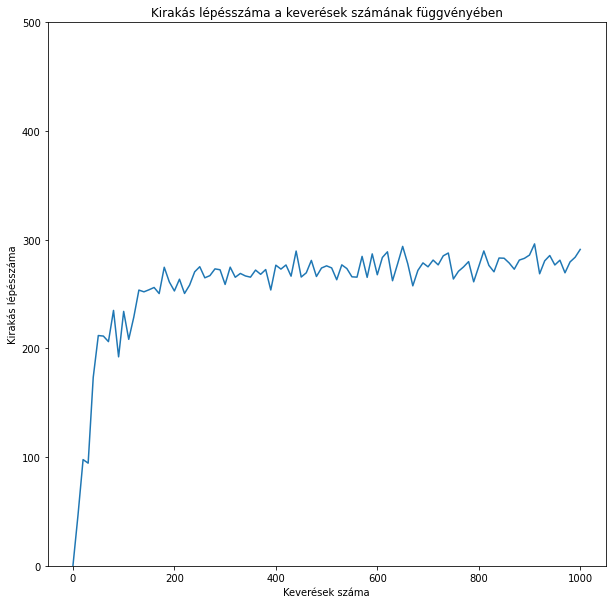

In [37]:
"""
Ez a script egy matplotlib-es abrat keszit, ami a keveresek szama es a kirakakas lepesszama kozti osszefuggest abrazolja
Gyorsabb futas erdekeben a h-t novelni, a rep-et csokkenteni lehet,
de ezek valtoztatasaval nagyobb kilengesek tapasztalhatoak
"""

N = 1000  # maximum ennyi keverest csinalunk
h = 10  # x tengelyen a lepeskoz
rep = 20  # ennyi pelda alapjan szamolom az atlagot minden keveres szamnal
x = np.linspace(0, N, int(N / h + 1))
y = np.zeros_like(x)

for i in range(0, N + h, h):
    atlag_lepeszam = 0
    for _ in range(rep):
        table = shuffle_position(num_of_shuffles=i)
        game = TologatosJatek(table)
        game.kirakas()
        atlag_lepeszam += game.lepesekszama
    atlag_lepeszam = atlag_lepeszam / rep
    y[int(i / 10)] = atlag_lepeszam

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
plt.plot(x, y)
plt.ylim(0, 500)
axs.set_title('Kirakás lépésszáma a keverések számának függvényében')
axs.set_ylabel('Kirakás lépésszáma')
axs.set_xlabel('Keverések száma')
plt.show()

In [38]:
df = pd.DataFrame(columns=('Kezdoallas', 'Lepesszam', 'Sikeres', 'Futasido (s)'))
num_of_rows = 1000

for i in range(num_of_rows):
    table = generate_start_position()  # generate a random start position
    start_position = table.reshape(16)
    game = TologatosJatek(table.copy())  # create a TologatosJatek object
    start_time = time.time()
    game.kirakas()  # solve the table
    runtime = round(time.time() - start_time, 5)
    num_of_steps = game.lepesekszama
    end_position = game.A.copy().reshape(16)
    expected_table = np.array(range(16))
    expected_table = np.roll(expected_table, -1)
    success = True if (end_position == expected_table).all() else False
    df.loc[i] = [start_position, num_of_steps, success, runtime]


In [39]:
df

,Kezdoallas,Lepesszam,Sikeres,Futasido (s)
0,"[8, 1, 5, 3, 2, 14, 11, 0, 15, 6, 9, 7, 13, 4,...",302,True,0.002
1,"[12, 9, 5, 0, 11, 13, 2, 15, 6, 10, 8, 1, 7, 3...",245,True,0.003
2,"[11, 8, 10, 6, 2, 14, 3, 4, 7, 9, 13, 15, 5, 1...",256,True,0.002
3,"[8, 2, 7, 12, 4, 10, 14, 0, 3, 9, 5, 15, 13, 1...",244,True,0.002
4,"[5, 12, 14, 4, 13, 3, 0, 7, 11, 1, 9, 15, 10, ...",305,True,0.002
...,...,...,...,...
995,"[5, 8, 3, 6, 1, 11, 4, 13, 0, 10, 12, 7, 14, 9...",274,True,0.001
996,"[7, 4, 5, 1, 8, 11, 3, 14, 13, 2, 12, 6, 10, 0...",296,True,0.002
997,"[10, 0, 2, 4, 6, 13, 1, 15, 3, 11, 5, 8, 9, 14...",255,True,0.001
998,"[3, 15, 13, 10, 2, 1, 6, 14, 4, 5, 7, 12, 11, ...",235,True,0.001


In [40]:
# A maximalis kirakasi lepesszam
df["Lepesszam"].max()

383

In [41]:
#A kirakasok atlagos lepesszama
df["Lepesszam"].mean()

278.486

In [42]:
#A legrosszabb futasido az algoritmusra 
df["Futasido (s)"].max()

0.006